# Tennis Action Recognition

In [1]:
import os
import glob
import math
import gc
import pickle
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# from tensorflow.keras.utils import np_utils, generic_utils
from tensorflow.keras.utils import to_categorical

#normalisation
from sklearn.preprocessing import StandardScaler

#model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from tensorflow.keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras import regularizers



In [6]:
img_rows, img_cols = 64, 64
nb_classes = 6
hm_frames = 70  # number of frames
patch_size = 35 # half frames

In [7]:
# classes label you want to use all labels
targets_name = [
                # 'backhand',
                # 'backhand2hands',
                'backhand_slice',
                'backhand_volley',
                'forehand_flat',
                'forehand_openstands',
                'forehand_slice',
                'forehand_volley',
                # 'smash'
                ]

## Preprocessing the frames

1. Unify frames to be 30 in each folder.
2. Resize the frames to 64x64 for input.
3. Convert them to grayscale.
4. Convert the list of frames to an np array.

In [32]:
def release_list(a):
    """Function to empty the RAM."""
    del a[:]
    del a
    gc.collect()

In [33]:
def get_unify_frames(path):
    """Unify number of frames for each training.
    
    Args:
        path: path to directory.
    """
    offset = 0

    # pick frames
    frames = os.listdir(path)
    frames_count = len(frames)

    if hm_frames > frames_count:
        # duplicate last frame if video is shorter than necessary
        frames += [frames[-1]] * (hm_frames - frames_count)
    elif hm_frames < frames_count:
        # if there are more frames, then sample starting offset
        frames = frames[0:hm_frames]
    return frames

In [34]:
def resize_frame(frame):
    """Resize frames.
    
    Args:
        frame: image to be resized.
    """
    frame = cv2.imread(frame)
    frame = cv2.resize(frame, (img_rows, img_cols))
    return frame

In [35]:
# Training 
counter = 0 # number of training
training_targets = [] # training targets 
new_frames = [] # training data after resize & unify

for dirs in targets_name:
    new_frame = []
    label = dirs
    dirs = 'dataset/train/' + dirs
    for folder in tqdm(sorted(glob.glob(dirs + '/*'))):
        frames = sorted(get_unify_frames(folder))
        if len(frames) == hm_frames: # just to be sure
            for frame in frames:
                frame = resize_frame(folder + '/' + frame)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                new_frame.append(frame)
                if len(new_frame) == patch_size: # partition each training on two trainings.
                    new_frames.append(new_frame) # append each partition to training data
                    training_targets.append(targets_name.index(label))
                    counter +=1
                    new_frame = []
                    gc.collect()

100%|██████████| 150/150 [02:57<00:00,  1.19s/it]


In [36]:
# Validation
counter = 0 # number of training
cv_targets = [] # training targets 
new_frames_cv = [] # training data after resize & unify

for dirs in targets_name:
    new_frame = []
    label = dirs
    dirs = 'dataset/validation/' + dirs
    for folder in tqdm(sorted(glob.glob(dirs + '/*'))):
        frames = sorted(get_unify_frames(folder))
        if len(frames) == hm_frames: # just to be sure
            for frame in frames:
                frame = resize_frame(folder + '/' + frame)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                new_frame.append(frame)
                if len(new_frame) == patch_size: # partition each training on two trainings.
                    new_frames_cv.append(new_frame) # append each partition to training data
                    cv_targets.append(targets_name.index(label))
                    counter +=1
                    new_frame = []
                    gc.collect()

100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


In [37]:
print("Train Images shape:", np.array(new_frames).shape)
print("Validation Images shape:", np.array(new_frames_cv).shape)
print("Train Labels shape:", np.array(training_targets).shape)
print("Test Labels shape:", np.array(cv_targets).shape)

Train Images shape: (2400, 35, 64, 64, 3)
Validation Images shape: (240, 35, 64, 64, 3)
Train Labels shape: (2400,)
Test Labels shape: (240,)


In [38]:
counter_training = int(300*6)
print(counter_training)
counter_validation = int(30*6)
print(counter_validation)

2400
240


In [39]:
# convert training data to np float32
training_data = np.array(new_frames[0:counter_training], dtype=np.float32)
training_targets = to_categorical(np.array(training_targets), 8)

print("Trainign data shape:", training_data.shape)
print("Training labels shape:", training_targets.shape)

Trainign data shape: (2400, 35, 64, 64, 3)
Training labels shape: (2400, 8)


In [40]:
# convert validation data to np float32
cv_data = np.array(new_frames_cv[0:counter_validation], dtype=np.float32)
cv_targets = to_categorical(np.array(cv_targets), 8)

print("Validation data shape:", cv_data.shape)
print("Validation labels shape:", cv_targets.shape)

Validation data shape: (240, 35, 64, 64, 3)
Validation labels shape: (240, 8)


In [41]:
gc.collect()

116

## Normalization

In [42]:
def normalization(data):
    print('old mean', data.mean())

    scaler = StandardScaler()

    scaled_images  = scaler.fit_transform(data.reshape(-1, patch_size*64*64))
    print('new mean', scaled_images.mean())
    
    scaled_images  = scaled_images.reshape(-1, patch_size, 64, 64, 3)    
    print(scaled_images.shape)
    
    return scaled_images

In [43]:
# Normalisation: training
scaled_images = normalization(training_data)

old mean 110.38819
new mean 1.6902174e-09
(2400, 35, 64, 64, 3)


In [44]:
# val = np.zeros((counter_validation, 35, 64, 64, 3))

# for h in range(counter_validation):
#     val[h][:][:][:][:]=cv_data[h,:,:,:]

In [45]:
# Normalisation: validation
scaled_images_cv = normalization(cv_data)

old mean 113.277214
new mean -4.7305276e-10
(240, 35, 64, 64, 3)


In [46]:
gc.collect()

75

In [47]:
# release_list(new_frames)
# release_list(new_frames_cv)

## Creating and training the model

In [8]:
weight_decay = 0.005
batch_size = 32
nb_epoch = 100

In [9]:
sgd = SGD(lr=0.005, momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1, decay=1e-6)

#checkpoints
checkpoint = ModelCheckpoint('notebook/weights_8TV/checkpoints',
                             monitor='val_acc',
                             save_best_only=True,
                             verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss',
                          patience=50,
                          verbose=1)

In [10]:
model = Sequential()
model.add(MaxPooling3D(pool_size=(1, 2, 2),
                       input_shape=(patch_size, 64, 64, 3)))

model.add(Conv3D(8,(5,5,5),activation='relu',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(32,(3,5,5), activation='relu',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(nb_classes,
                kernel_initializer='normal',
                kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Activation('softmax'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d (MaxPooling3D) (None, 35, 32, 32, 3)     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 31, 28, 28, 8)     3008      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 31, 14, 14, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 29, 10, 10, 32)    19232     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 14, 5, 5, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 11200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)              

In [69]:
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['acc'])

In [70]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.05, 
                               cooldown=0,
                               patience=10,
                               min_lr=0.005/(2^4),
                               verbose=1)

In [64]:
hist = model.fit(scaled_images,
                 training_targets,
                 validation_data=(scaled_images_cv,cv_targets),
                 batch_size=batch_size,
                 epochs = nb_epoch,
                 shuffle=True,
                 callbacks=[checkpoint,lr_reducer],)

Epoch 1/50
150/150 [==============================] - 11s 62ms/step - loss: 5.7532 - acc: 0.1258 - val_loss: 5.4730 - val_acc: 0.1583

Epoch 00001: val_acc improved from -inf to 0.15833, saving model to notebook/weights_8TV\checkpoints
INFO:tensorflow:Assets written to: notebook/weights_8TV\checkpoints\assets
Epoch 2/50
150/150 [==============================] - 9s 58ms/step - loss: 5.2313 - acc: 0.1317 - val_loss: 5.0024 - val_acc: 0.1125

Epoch 00002: val_acc did not improve from 0.15833
Epoch 3/50
150/150 [==============================] - 9s 57ms/step - loss: 4.7868 - acc: 0.1471 - val_loss: 4.6036 - val_acc: 0.1208

Epoch 00003: val_acc did not improve from 0.15833
Epoch 4/50
150/150 [==============================] - 9s 59ms/step - loss: 4.4018 - acc: 0.1713 - val_loss: 4.2645 - val_acc: 0.1542

Epoch 00004: val_acc did not improve from 0.15833
Epoch 5/50
150/150 [==============================] - 9s 58ms/step - loss: 3.9940 - acc: 0.2117 - val_loss: 4.0849 - val_acc: 0.1333

Epo

KeyboardInterrupt: 

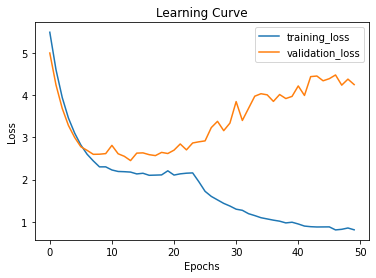

In [55]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

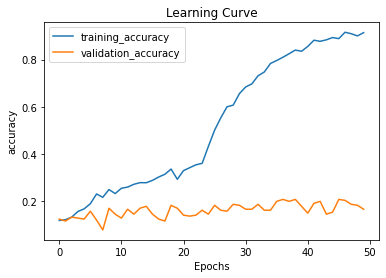

In [56]:
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [57]:
stop

NameError: name 'stop' is not defined